# Physical Activity Classification

### Siem Yonas

In [1]:
import numpy as np 
import pandas as pd 

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# !! Make sure to have the imblearn library !!
from imblearn.combine import SMOTETomek 

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
def plot_confusion_matrix(y_test, y_pred):
    labels = np.unique(np.append(y_test, y_pred))
    n_classes = len(labels)
    
    matrix = confusion_matrix(y_test, y_pred, labels=labels)
    matrix_norm = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(8, 8))
    plt.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
    plt.imshow(matrix_norm, cmap='hot')
    plt.yticks(np.arange(n_classes),labels)
    plt.xticks(np.arange(n_classes),labels, rotation=90)
    plt.ylabel("Actual Class")
    plt.xlabel("Predicted Class")
    plt.colorbar()
    plt.gca().xaxis.set_label_position('top')
    plt.title("Confusion Matrix")
    
    
    for i in range(n_classes):
        for j in range(n_classes):
            text = plt.text(j, i, matrix[i, j],
                           ha="center", va="center", color="w" if matrix_norm[i,j] < 0.5 else "k")
        
    plt.show()
    
    return matrix
    

# Dataset Description

This dataset is a modified version of the [PAMAP2 Physical Activity Monitoring dataset](https://archive.ics.uci.edu/dataset/231/pamap2+physical+activity+monitoring) compiled on Kaggle by user [Diego Silva](https://www.kaggle.com/diegosilvadefrana) as the [Physical Activity Prediction Dataset](https://www.kaggle.com/datasets/diegosilvadefrana/fisical-activity-dataset)

In this dataset, 8 participants perform 12 different tasks wearing 3 inertial measurement units and a heart rate monitor

This is a 33 feature x 2864056 observation dataset.

## Features:
- [1] Participant ID (Nominal)
- [1] Heart Rate ($bpm$) (Quantative)
- For each Inertial Measurment Unit {Hand|Chest|Ankle}
    - [3] {Unit} Temperature ($°C$) (Quantative)
    - [9] {Unit} Acceleration {X|Y|Z} ($m/s^2$) (Quantative)
    - [9] {Unit} Gyroscope {X|Y|Z} ($rad/s$) (Quantative)
    - [9] {Unit} Magnetometer {X|Y|Z} ($T$) (Quantative)
- [1] Activity ID (Nominal)

The activities being tested are:
- Nordic Walking
- Ascending Stairs
- Cycling
- Descending Stairs
- Ironing
- Lying
- Rope Jumping
- Running
- Sitting
- Standing
- Vacuum Cleaning
- Walking

There is also an ID for "Transient Activities", which are the class for data points measured between activities.  

## Data Cleanup

Only 46 of the ~3 million observations have null values, so it is safe to just drop null values from the dataset.

```
Null Value Counts:
activityID                    0
heart_rate                   46
hand temperature (°C)         0
hand acceleration X ±16g      0
hand acceleration Y ±16g      0
hand acceleration Z ±16g      0
hand gyroscope X              0
hand gyroscope Y              0
hand gyroscope Z              0
hand magnetometer X           0
hand magnetometer Y           0
hand magnetometer Z           0
chest temperature (°C)        0
chest acceleration X ±16g     0
chest acceleration Y ±16g     0
chest acceleration Z ±16g     0
chest gyroscope X             0
chest gyroscope Y             0
chest gyroscope Z             0
chest magnetometer X          0
chest magnetometer Y          0
chest magnetometer Z          0
ankle temperature (°C)        0
ankle acceleration X ±16g     0
ankle acceleration Y ±16g     0
ankle acceleration Z ±16g     0
ankle gyroscope X             0
ankle gyroscope Y             0
ankle gyroscope Z             0
ankle magnetometer X          0
ankle magnetometer Y          0
ankle magnetometer Z          0
PeopleId                      0
```

From this null-dropped dataset, 2000 observations are sampled for the cleaned dataset sample. 


For our quantitive features, we have the following descriptive statistics:
```
                                 mean        std
heart_rate                 108.894027  25.467962
hand temperature (°C)       32.730812   1.783761
hand acceleration X ±16g    -4.986153   5.732203
hand acceleration Y ±16g     3.596237   6.016860
hand acceleration Z ±16g     3.290629   3.617608
hand gyroscope X             0.018309   1.272705
hand gyroscope Y             0.034118   0.869606
hand gyroscope Z             0.005930   1.324318
hand magnetometer X         21.727125  23.908574
hand magnetometer Y        -14.872574  24.386182
hand magnetometer Z        -21.109192  20.445225
chest temperature (°C)      36.205750   1.551350
chest acceleration X ±16g    0.434751   1.554340
chest acceleration Y ±16g    8.599267   4.124274
chest acceleration Z ±16g   -1.389890   4.187285
chest gyroscope X            0.013178   0.419953
chest gyroscope Y           -0.006130   0.536116
chest gyroscope Z           -0.013533   0.287507
chest magnetometer X         3.043430  16.261874
chest magnetometer Y       -31.527293  16.171160
chest magnetometer Z         5.240440  19.903208
ankle temperature (°C)      33.736656   1.167776
ankle acceleration X ±16g    9.535452   6.387916
ankle acceleration Y ±16g   -0.146950   6.771129
ankle acceleration Z ±16g   -2.452689   4.076279
ankle gyroscope X            0.017194   1.087460
ankle gyroscope Y           -0.055653   0.584054
ankle gyroscope Z            0.011482   1.810095
ankle magnetometer X       -33.136241  19.174488
ankle magnetometer Y         1.352284  21.757421
ankle magnetometer Z        17.766967  19.555263
```

The variances of the heart rate monitors and the magnetometer features are much higher than the rest. Also, these features along with the temperature have means far from 0. These features can be normalized, but as seen later, this is unnecessary.

# Project Goal

**This project aims to classify what activity a user is doing given some health and inertial monitoring data.**

In other words, given the 31 input features:
- [1] Heart Rate
- [3] {Hand|Chest|Ankle} Temperature
- [9] {Hand|Chest|Ankle} Acceleration {X|Y|Z} 
- [9] {Hand|Chest|Ankle} Gyroscope {X|Y|Z}
- [9] {Hand|Chest|Ankle} Magnetometer {X|Y|Z}

Classify:
- [1] Activity ID

## Model Selection
Since there are a lot of features, kNN would not work well due to the Curse of Dimensionality, and a Decision Tree would at best perform moderately. Thus, a **Random Forest Classifier** with **100 estimators** was chosen for the model, combining the mediocre results of multiple Decision Trees given lower numbers of features to get a decently performing classifier. At the very least, **this model is expected to have >70% accuracy**. Another upside of using Random Forest Classification is that because tree classifiers are being used, [no data normalization is needed](https://towardsdatascience.com/how-data-normalization-affects-your-random-forest-algorithm-fbc6753b4ddf), saving a step in the model pipeline.

## Model Evaluation
Data is split into training and test data (with an 80-20 split), then the training data is further split into true training data and validation data (also, with an 80-20 split).
Since this is a classification model, **the model will primary be evaluated through f1-score**, as well as precision, recall, and accuracy.
Confusion matricies also serve to visually evaluate the model.

# Data Preparation

In [3]:
df_sample = pd.read_csv("physical_activity_sample4.csv")

In [4]:
y = df_sample["activityID"].apply(lambda x: x.title())
X = df_sample.drop(columns=["activityID", "PeopleId"])

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=0.2, 
                                                  random_state=42)

# Model Training

## Max Depth Parameter Search

In [6]:
depths = list(range(1, 20))

def depth_score(depth):
    model = RandomForestClassifier(max_depth=depth, random_state=42).fit(X_train, y_train)
    return 1 - model.score(X_val, y_val)

accs = list(map(depth_score, depths))

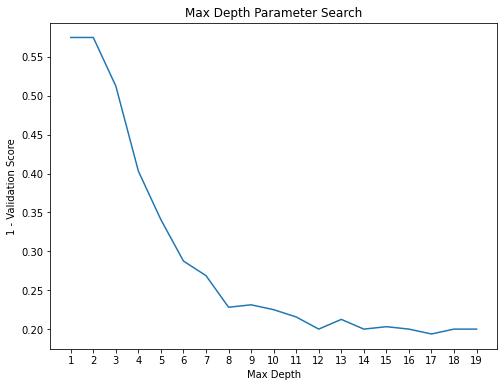

In [7]:
fig = plt.figure(figsize=(8, 6))
plt.plot(depths, accs)
plt.title("Max Depth Parameter Search")
plt.xlabel("Max Depth")
plt.xticks(depths)
_ = plt.ylabel("1 - Validation Score")

Across multiple random states, the model tends to level off in accuracy around 8-12, so 10 is chosen for the max depth.

## Model Fitting and Results

In [8]:
rf_clf = RandomForestClassifier(max_depth=10, random_state=42)
rf_clf.fit(X_train, y_train)

y_pred = rf_clf.predict(X_test)
rf_report = classification_report(y_test, y_pred)
print(rf_report)

                      precision    recall  f1-score   support

    Ascending Stairs       0.50      0.06      0.11        16
             Cycling       0.81      0.68      0.74        19
   Descending Stairs       1.00      0.20      0.33        20
             Ironing       0.69      0.95      0.80        19
               Lying       1.00      0.93      0.96        27
      Nordic Walking       0.87      0.62      0.72        21
        Rope Jumping       1.00      0.67      0.80         6
             Running       1.00      0.82      0.90        11
             Sitting       0.96      0.90      0.93        30
            Standing       0.96      0.76      0.85        33
Transient Activities       0.65      0.91      0.76       150
     Vacuum Cleaning       0.90      0.50      0.64        18
             Walking       0.79      0.63      0.70        30

            accuracy                           0.76       400
           macro avg       0.86      0.66      0.71       400
      

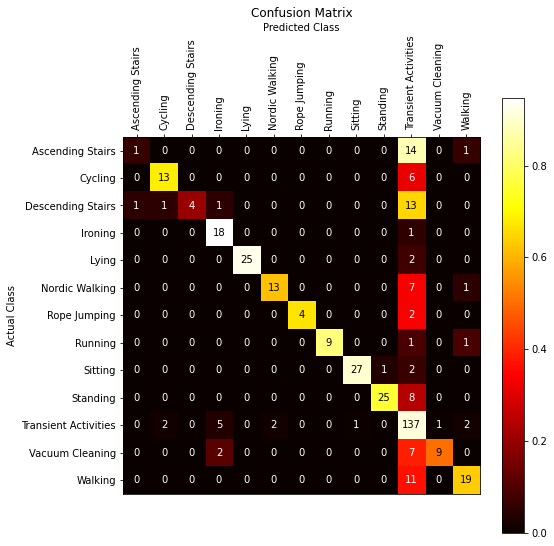

In [9]:
_ = plot_confusion_matrix(y_test, y_pred)

# Model Results Intrepretation

With the current random state, the model has an overall accuracy of 76%


From the activities, the model was very good at classifying ($F_1 \ge 0.90$):
- Lying (0.96)
- Sitting (0.93)
- Running (0.90)

Good at classifying ($0.80 \le F_1 < 0.90$):
- Standing (0.85)
- Ironing (0.80)
- Rope Jumping (0.80)

Ok at classifying ($0.50 \le F_1 < 0.80$):
- Transient Activities (0.76)
- Cycling (0.74)
- Nordic Walking (0.72)
- Walking (0.70)
- Vacuum Cleaning (0.64)

Poor at classifying ($F_1 < 0.50$):
- Descending Stairs (0.33)
- Ascending Stairs (0.11)

For these activities with lower f1-scores, there is high precision, but very low recall. Looking at the confusion matrix, we see a large amount of these misclassifications being classified as transient activities, which is reflected in the lower precision value for transient activities.

# Current Model Issues

There is heavy confusion between transient activities and most of the other activities. As a result, many of the other activities are misclassified as a transient activity.


Currently, there is a strong class imbalance in the data. In the original dataset, transient activities make up almost a third of all activities measured! A similiar effect can be seen in our training data:

In [10]:
y_train.value_counts()

activityID
Transient Activities    421
Ironing                 115
Walking                 113
Standing                107
Sitting                  81
Nordic Walking           77
Vacuum Cleaning          68
Lying                    67
Cycling                  63
Ascending Stairs         54
Descending Stairs        50
Running                  46
Rope Jumping             18
Name: count, dtype: int64

## Solution

We can fix the class imbalance by:
- Upsampling minority classes
- Downsampling majority classes


This can be done through SMOTE (oversampling) and Tomek links (undersampling), using imbalanced-learn's [SMOTETomek](https://imbalanced-learn.org/stable/references/generated/imblearn.combine.SMOTETomek.html)

In [11]:
smt = SMOTETomek(random_state=123)
X_tmk, y_tmk = smt.fit_resample(X_train, y_train) 

In [12]:
y_tmk.value_counts()

activityID
Ironing                 421
Rope Jumping            421
Cycling                 421
Standing                421
Running                 421
Vacuum Cleaning         421
Descending Stairs       421
Ascending Stairs        421
Sitting                 421
Nordic Walking          420
Lying                   419
Walking                 419
Transient Activities    416
Name: count, dtype: int64

# New Model Training

In [13]:
rf_clf_tmk = RandomForestClassifier(max_depth=10, random_state=42)
rf_clf_tmk.fit(X_tmk, y_tmk)

y_pred = rf_clf_tmk.predict(X_test)
rf_tmk_report = classification_report(y_test, y_pred)
print(rf_tmk_report)

                      precision    recall  f1-score   support

    Ascending Stairs       0.62      0.62      0.62        16
             Cycling       0.74      0.89      0.81        19
   Descending Stairs       0.54      0.75      0.63        20
             Ironing       0.49      0.95      0.64        19
               Lying       1.00      0.93      0.96        27
      Nordic Walking       0.71      0.95      0.82        21
        Rope Jumping       0.71      0.83      0.77         6
             Running       0.69      0.82      0.75        11
             Sitting       0.90      0.93      0.92        30
            Standing       0.86      0.94      0.90        33
Transient Activities       0.88      0.59      0.70       150
     Vacuum Cleaning       0.73      0.61      0.67        18
             Walking       0.63      0.87      0.73        30

            accuracy                           0.76       400
           macro avg       0.73      0.82      0.76       400
      

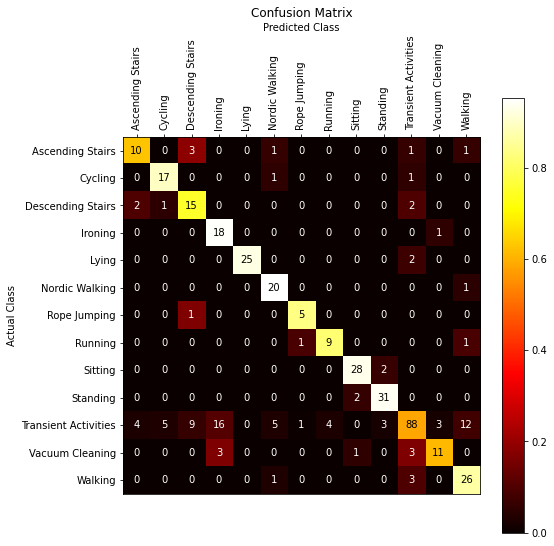

In [14]:
_ = plot_confusion_matrix(y_test, y_pred)

# New Model Results

With the current random state, this model has the same overall accuracy of 76%. Looking at our f1-scores, however, there is a major improvement in the lower performing classifications.


## Major changes:

Better classification for a good chunk of classes *(No activity has "Poor" classification anymore!)*:
- Standing (0.85 -> 0.90) [Good -> Very Good]
- Nordic Walking (0.72 -> 0.82) [Ok -> Good]
- Cycling (0.74 -> 0.81) [Ok -> Good]
- Descending Stairs (0.33 -> 0.63) [Poor -> Ok]
- Ascending Stairs (0.11 -> 0.62) [Poor -> Ok]

But at the cost of worse classification for some classes:
- Running (0.90 -> 0.75) [Very Good -> Ok]
- Rope Jumping (0.80 -> 0.77) [Good -> Ok]
- Ironing (0.80 -> 0.64) [Good -> Ok]

# Possible Extensions

In the future, these other modifications could be investigated:
- One-vs-All v.s. One-vs-One classification
- AdaBoost using Decision Trees
- Stacking and Voting with other types of classifiers
- Dimensionality Reduction
  - PCA
  - Removing Features by Feature Importance

# Thank You!

Libraries used:
- jupyter (lab, nbconvert)
- numpy
- matplotlib
- pandas
- scikit-learn
- imbalanced-learn

References:
- [PAMAP2 Physical Activity Monitoring dataset](https://archive.ics.uci.edu/dataset/231/pamap2+physical+activity+monitoring) 
- [Physical Activity Prediction Dataset](https://www.kaggle.com/datasets/diegosilvadefrana/fisical-activity-dataset) compiled by Kaggle user [Diego Silva](https://www.kaggle.com/diegosilvadefrana)
- [How data normalization affects your Random Forest algorithm](https://towardsdatascience.com/how-data-normalization-affects-your-random-forest-algorithm-fbc6753b4ddf) by towardsdatascience writer [Javier Fernandez](https://javiferfer.medium.com/)
- [Combining SMOTE with Tomek Links for imbalanced classification in Python](https://towardsdatascience.com/imbalanced-classification-in-python-smote-tomek-links-method-6e48dfe69bbc) by towardsdatascience writer [Raden Aurelius Andhika Viadinugroho](https://medium.com/@radenaurelius)



# EXTRA (Testing with other data sets!)

In [15]:
df_sample_2 = pd.read_csv("physical_activity_sample1.csv")

y_test_2 = df_sample_2["activityID"].apply(lambda x: x.title())
X_test_2 = df_sample_2.drop(columns=["activityID", "PeopleId"])

                      precision    recall  f1-score   support

    Ascending Stairs       0.50      0.03      0.06        92
             Cycling       0.87      0.76      0.81       115
   Descending Stairs       0.90      0.11      0.20        80
             Ironing       0.91      0.90      0.91       181
               Lying       1.00      0.91      0.95       138
      Nordic Walking       0.91      0.55      0.69       129
        Rope Jumping       1.00      0.46      0.63        24
             Running       0.88      0.78      0.82        72
             Sitting       1.00      0.94      0.97       128
            Standing       0.88      0.69      0.78       117
Transient Activities       0.60      0.93      0.72       628
     Vacuum Cleaning       0.82      0.55      0.66       116
             Walking       0.82      0.72      0.77       180

            accuracy                           0.75      2000
           macro avg       0.85      0.64      0.69      2000
      

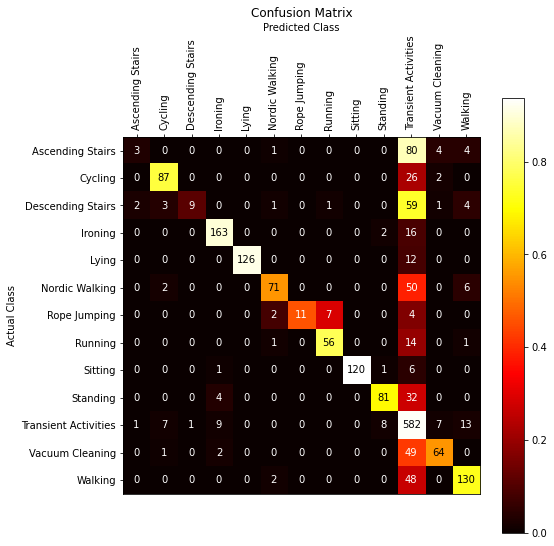

array([[  3,   0,   0,   0,   0,   1,   0,   0,   0,   0,  80,   4,   4],
       [  0,  87,   0,   0,   0,   0,   0,   0,   0,   0,  26,   2,   0],
       [  2,   3,   9,   0,   0,   1,   0,   1,   0,   0,  59,   1,   4],
       [  0,   0,   0, 163,   0,   0,   0,   0,   0,   2,  16,   0,   0],
       [  0,   0,   0,   0, 126,   0,   0,   0,   0,   0,  12,   0,   0],
       [  0,   2,   0,   0,   0,  71,   0,   0,   0,   0,  50,   0,   6],
       [  0,   0,   0,   0,   0,   2,  11,   7,   0,   0,   4,   0,   0],
       [  0,   0,   0,   0,   0,   1,   0,  56,   0,   0,  14,   0,   1],
       [  0,   0,   0,   1,   0,   0,   0,   0, 120,   1,   6,   0,   0],
       [  0,   0,   0,   4,   0,   0,   0,   0,   0,  81,  32,   0,   0],
       [  1,   7,   1,   9,   0,   0,   0,   0,   0,   8, 582,   7,  13],
       [  0,   1,   0,   2,   0,   0,   0,   0,   0,   0,  49,  64,   0],
       [  0,   0,   0,   0,   0,   2,   0,   0,   0,   0,  48,   0, 130]],
      dtype=int64)

In [16]:
y_pred_2 = rf_clf.predict(X_test_2)

print(classification_report(y_test_2, y_pred_2))
plot_confusion_matrix(y_test_2, y_pred_2)

                      precision    recall  f1-score   support

    Ascending Stairs       0.47      0.61      0.53        92
             Cycling       0.85      0.87      0.86       115
   Descending Stairs       0.41      0.49      0.45        80
             Ironing       0.78      0.96      0.86       181
               Lying       1.00      0.91      0.95       138
      Nordic Walking       0.71      0.87      0.78       129
        Rope Jumping       0.78      0.58      0.67        24
             Running       0.63      0.86      0.73        72
             Sitting       0.91      0.97      0.94       128
            Standing       0.75      0.83      0.79       117
Transient Activities       0.83      0.57      0.68       628
     Vacuum Cleaning       0.70      0.78      0.73       116
             Walking       0.71      0.86      0.78       180

            accuracy                           0.75      2000
           macro avg       0.73      0.78      0.75      2000
      

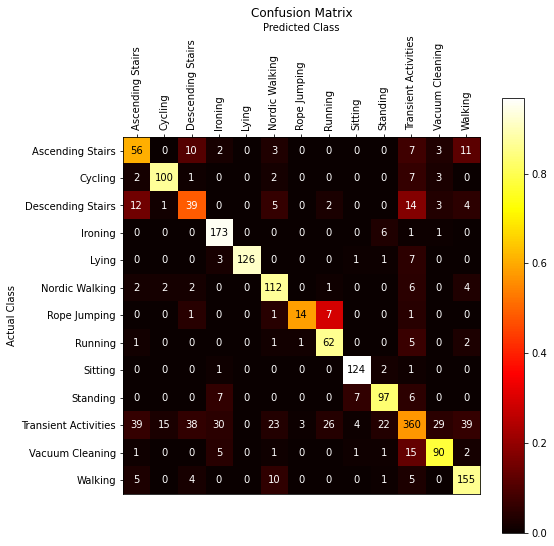

array([[ 56,   0,  10,   2,   0,   3,   0,   0,   0,   0,   7,   3,  11],
       [  2, 100,   1,   0,   0,   2,   0,   0,   0,   0,   7,   3,   0],
       [ 12,   1,  39,   0,   0,   5,   0,   2,   0,   0,  14,   3,   4],
       [  0,   0,   0, 173,   0,   0,   0,   0,   0,   6,   1,   1,   0],
       [  0,   0,   0,   3, 126,   0,   0,   0,   1,   1,   7,   0,   0],
       [  2,   2,   2,   0,   0, 112,   0,   1,   0,   0,   6,   0,   4],
       [  0,   0,   1,   0,   0,   1,  14,   7,   0,   0,   1,   0,   0],
       [  1,   0,   0,   0,   0,   1,   1,  62,   0,   0,   5,   0,   2],
       [  0,   0,   0,   1,   0,   0,   0,   0, 124,   2,   1,   0,   0],
       [  0,   0,   0,   7,   0,   0,   0,   0,   7,  97,   6,   0,   0],
       [ 39,  15,  38,  30,   0,  23,   3,  26,   4,  22, 360,  29,  39],
       [  1,   0,   0,   5,   0,   1,   0,   0,   1,   1,  15,  90,   2],
       [  5,   0,   4,   0,   0,  10,   0,   0,   0,   1,   5,   0, 155]],
      dtype=int64)

In [17]:
y_pred_2 = rf_clf_tmk.predict(X_test_2)

print(classification_report(y_test_2, y_pred_2))
plot_confusion_matrix(y_test_2, y_pred_2)